In [2]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.applications. resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import optimizers

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report

c:\Users\Tácio\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
train_data_dir = r"InceptionResNetV2/images_splitted_aug_v3/train"
valid_data_dir = r"InceptionResNetV2/images_splitted_aug_v3/val"
test_data_dir = r"InceptionResNetV2/images_splitted_aug_v3/test"


In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    validation_split = 0.4)
    


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(244, 244),
    batch_size = 32,
    class_mode = 'categorical',
    subset= 'training') # set as training data


valid_generator = train_datagen.flow_from_directory(
    valid_data_dir, # same directory as training data
    target_size=(244, 244),
    batch_size=32,
    class_mode ='categorical',
    subset='validation') # set as validation data

   


Found 4960 images belonging to 7 classes.
Found 940 images belonging to 7 classes.


In [10]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir, # same directory as training data
    target_size=(244, 244),
    batch_size=1,
    class_mode= 'categorical',
    subset= "validation") # set as validation data


Found 472 images belonging to 7 classes.


In [146]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : classe_1
1 : classe_2
2 : classe_3
3 : classe_4
4 : classe_5
5 : classe_6
6 : classe_7


In [147]:
x,y = test_generator.next()
x.shape


(1, 244, 244, 3)

In [148]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [150]:
base_model = InceptionResNetV2(include_top=False, weights="imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model. layers:
    layer.trainable = False

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])

hist = model.fit(train_generator, epochs = 200, validation_data=valid_generator, verbose = 2, callbacks=[reduce_lr])


Epoch 1/200
155/155 - 54s - loss: 35.5496 - accuracy: 0.2635 - val_loss: 18.0383 - val_accuracy: 0.2255 - lr: 0.0010 - 54s/epoch - 349ms/step
Epoch 2/200
155/155 - 33s - loss: 5.0002 - accuracy: 0.2708 - val_loss: 3.3772 - val_accuracy: 0.4096 - lr: 0.0010 - 33s/epoch - 210ms/step
Epoch 3/200
155/155 - 33s - loss: 3.0844 - accuracy: 0.2863 - val_loss: 2.4436 - val_accuracy: 0.1628 - lr: 0.0010 - 33s/epoch - 210ms/step
Epoch 4/200
155/155 - 33s - loss: 2.4663 - accuracy: 0.2994 - val_loss: 2.5588 - val_accuracy: 0.4074 - lr: 0.0010 - 33s/epoch - 212ms/step
Epoch 5/200
155/155 - 33s - loss: 2.6189 - accuracy: 0.2843 - val_loss: 2.4521 - val_accuracy: 0.4096 - lr: 0.0010 - 33s/epoch - 213ms/step
Epoch 6/200
155/155 - 33s - loss: 1.9019 - accuracy: 0.3173 - val_loss: 1.7783 - val_accuracy: 0.3479 - lr: 0.0010 - 33s/epoch - 213ms/step
Epoch 7/200
155/155 - 33s - loss: 1.9705 - accuracy: 0.3224 - val_loss: 2.1712 - val_accuracy: 0.1191 - lr: 0.0010 - 33s/epoch - 213ms/step
Epoch 8/200
155/15

Plot da acurária de treino e validação, loss e learning rate


In [151]:
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

learning_rate = hist.history['lr']

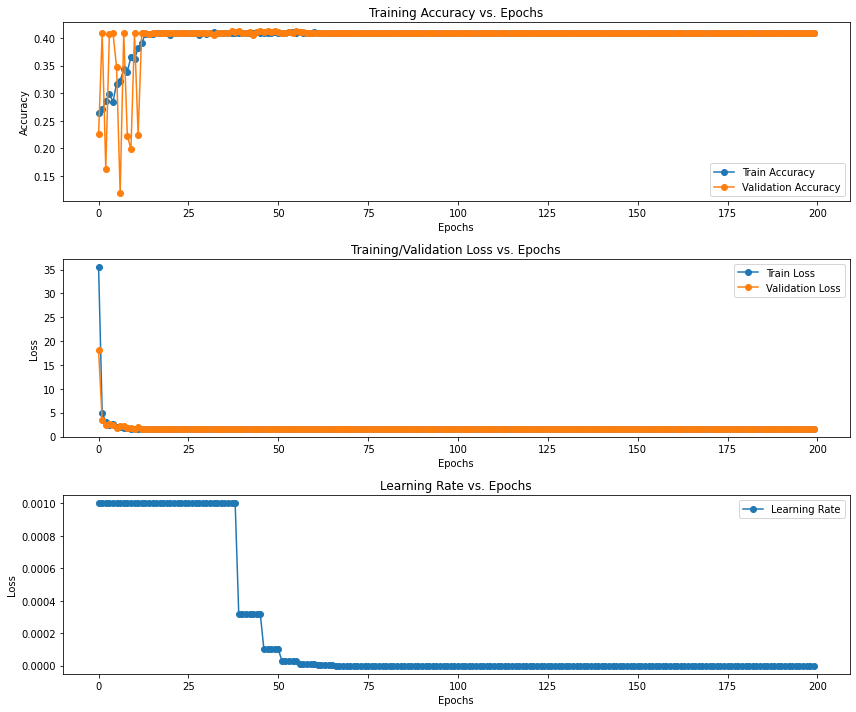

In [152]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

Acurácia e Loss de Teste

In [154]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

472/472 [==============================] - 19s 41ms/step - loss: 1.5684 - accuracy: 0.4089


In [120]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     1.6530636548995972
Test Accuracy: 0.3919491469860077


======================
Matriz de Confusão


In [155]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

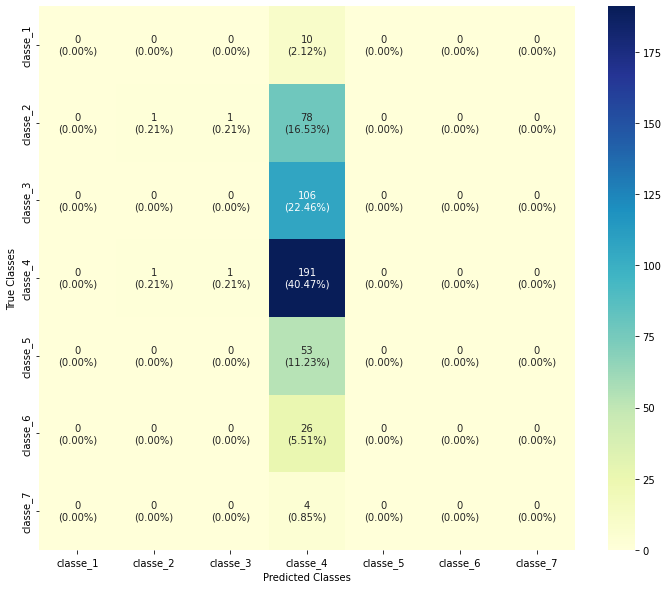

In [156]:
import seaborn as sns

cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(7, 7)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

--------------------------------------------------------------------


In [157]:
print(classification_report(y_true, y_pred, target_names=labels.values()))


              precision    recall  f1-score   support

    classe_1       0.00      0.00      0.00        10
    classe_2       0.50      0.01      0.02        80
    classe_3       0.00      0.00      0.00       106
    classe_4       0.41      0.99      0.58       193
    classe_5       0.00      0.00      0.00        53
    classe_6       0.00      0.00      0.00        26
    classe_7       0.00      0.00      0.00         4

    accuracy                           0.41       472
   macro avg       0.13      0.14      0.09       472
weighted avg       0.25      0.41      0.24       472



c:\Users\Tácio\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tácio\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tácio\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Predições erradas -----------------------------------------------------


In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [158]:
model.save('InceptionResNetV2')


INFO:tensorflow:Assets written to: resnet_50\assets


INFO:tensorflow:Assets written to: resnet_50\assets


: 

In [99]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)


472/472 - 25s - loss: 1.5793 - accuracy: 0.4089 - 25s/epoch - 53ms/step

Test accuracy: 0.4088982939720154


-----------------------------------------------------


In [4]:
model2 = tf.keras.models.load_model('InceptionResNetV2')

In [11]:
test_loss, test_accuracy = model2.evaluate(test_generator, batch_size=32)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

472/472 [==============================] - 28s 41ms/step - loss: 1.5684 - accuracy: 0.4089
Test Loss:     1.5683661699295044
Test Accuracy: 0.4088982939720154
